In [1]:
import os
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth
from PIL import Image
import matplotlib.pyplot as plt



In [2]:
# loading images from the training set of city scape data 
def LoadImage(name, path="cityscapes_data\\cityscapes_data\\train",
             rotation=0.0, flip=False, cut_bottom=58,
             size=(256, 200)):
    img = Image.open(path+"\\"+name)
    img = np.array(img)
    # second part of the appended image is the already segmented image 
    seg = img[:-cut_bottom, 256:]
    # 1st part is the original image without segmentation
    img = img[:-cut_bottom, 0:256]
    
    #Brighter image will have all pixels confined to high values.
    #But a good image will have pixels from all regions of the image. 
    # So we need to stretch this histogram to either ends and that is what Histogram Equalization does (in simple words).
    # This normally improves the contrast of the image.
    #for that we will be using the cv2.equalizeHist for this  purpose
    for i in range(3):
        zimg = img[:,:,i]
        zimg = cv2.equalizeHist(zimg)
        img[:,:,i] = zimg
    
    #take the matrix as the input and returns the image object CASA format return
    img = Image.fromarray(img).resize(size)
    seg = Image.fromarray(seg).resize(size)
    
    
   #simpe data augmentation options such as flipping and rotating
    img = img.rotate(rotation)
    seg = seg.rotate(rotation)

    img = np.array(img)
    seg = np.array(seg)

    if flip:
        img = img[:,::-1,:]
        seg = seg[:,::-1,:]

    # Returning the image in normalized form 
    return img/255, seg/255

In [3]:
#loading image formm the training set by giving path 
mypath = "cityscapes_data\\cityscapes_data\\train"
files = os.listdir(mypath)[0:10]

Text(0.5, 1.0, '(200, 256, 3)')

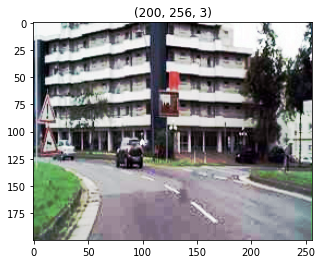

In [4]:
img, seg = LoadImage("1.jpg")
img = np.array(img)

# saving the img shape
shape = img.shape

# reshaping img 
reshape_img = np.reshape(img, [-1, 3])

#plotting the img
plt.imshow(img)
plt.title(img.shape)

In [5]:
bandwidth = estimate_bandwidth(reshape_img, quantile=0.1, n_samples=100)
bandwidth

0.12393317430486667

In [6]:
msc = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msc.fit(reshape_img)

MeanShift(bandwidth=0.12393317430486667, bin_seeding=True)

In [7]:
print("shape of labels : %d" % msc.labels_.shape)
print( msc.cluster_centers_.shape)
print("number of estimated clusters : %d" % len(np.unique(msc.labels_)))

shape of labels : 51200
(8, 3)
number of estimated clusters : 8


In [8]:
labels = msc.labels_
result_image = np.reshape(labels, shape[:2])

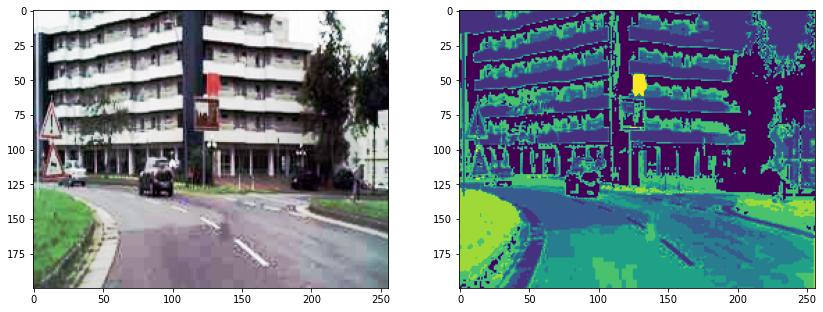

In [9]:
fig = plt.figure(2, figsize=(14, 12))
ax = fig.add_subplot(121)
ax = plt.imshow(img) 
ax = fig.add_subplot(122)
ax = plt.imshow(result_image)  
plt.show()

In [10]:
def LayersToRGBImage(img):
    colors = [(255,0,0), (0,255,0), (0,0,255),
             (255,255,0), (255,0,255), (0,255,255),
             (255,255,255), (200,50,0),(50,200,0),
             (50,0,200), (200,200,50), (0,50,200),
             (0,200,50), (0,0,0)]
    
    nimg = np.zeros((img.shape[0], img.shape[1], 3))
    for i in range(img.shape[2]):
        c = img[:,:,i]
        col = colors[i]
        
        for j in range(3):
            nimg[:,:,j]+=col[j]*c
    nimg = nimg/255.0
    return nimg

In [11]:
#This function converts the discrete color representation (output of the color clustering) to a 13-dimensional class representation
def ColorsToClass(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = msc.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    n = len(msc.cluster_centers_)
    
    cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        m = np.copy(s)
        m[m!=i] = 0
        m[m!=0] = 1
        
        cls[:,:,i]=m
        
    return cls

Text(0.5, 1.0, 'semantic segmented image using mean shift ')

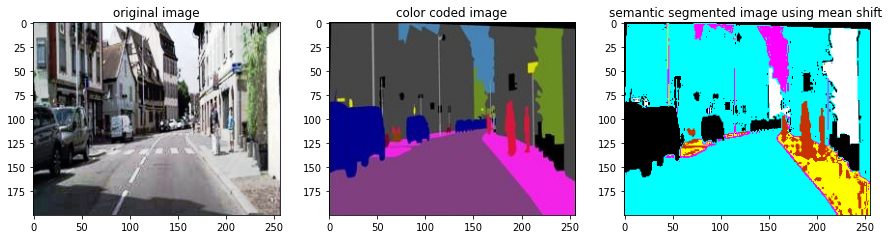

In [15]:
img, seg = LoadImage("2251.jpg")
seg2 = ColorsToClass(seg)
seg2 = LayersToRGBImage(seg2)
total = cv2.addWeighted(img, 0.6, seg2, 0.4, 0)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img)
axes[0].set_title("original image")
axes[1].imshow(seg)
axes[1].set_title("color coded image")
axes[2].imshow(seg2)
axes[2].set_title("semantic segmented image using mean shift ")